## Материалы
* [Презентация](https://disk.yandex.ru/i/0BJLLawrH6ICXA)
* [Дашборд](https://public.tableau.com/views/Starbrothersgameanalisys/sheet2?:language=en-US&:display_count=n&:origin=viz_share_link)

# Оглавление

1. [Просмотр данных из файлов](#start)
2. [Предобработка данных](#preprocessing)
3. [Исследовательский анализ данных](#eda)
    * [Активность игроков](#3.1)
    * [Достижение целевого события](#3.2)
    * [Затраты на привлечение игроков](#3.3)
    * [Активность игроков из разных источников](#3.4)
4. [Проверка гипотез](#verification)
    * [Различается ли среднее время прохождения первого уровня игроками победившими врага и выполневшими проект](#4.1)
    * [Можно ли сказать, что с определенного источника приходят любители определенной стратегии](#4.2)
5. [Модель монетизации](#monetization_model)
5. [Маркетинг](#marketing)
    * [Расчет LTV](#5.1)
6. [Общий вывод](#conclusion)
7. [Рекомендации](#recommendations)



## Задание

**Контекст**

Анализ проводится для маркетингового отдела заказчика.


Многие игры зарабатывают с помощью рекламы, и все они сталкиваются с противоречием:
 - Пользователь разозлится и уйдёт, если начать показывать ему рекламу раньше, чем игра его затянет.
 - Но чем позже создатели игры включат рекламу, тем меньше они заработают.

Необходимо сформировать модель монетизации игрового приложения: 
 - Помочь заказчику выбрать оптимальное время для запуска рекламы. 
 - Зная расходы на продвижение игры, рассчитать её окупаемость при разных сценариях.

Игра «Космические братья». <br>В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.
Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

Представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:
 - Победа над первым врагом;
 - Реализация проекта - разработка орбитальной сборки спутников.

Для того что бы понять будет ли эфективна предполагаемая заказчиком система показа рекламы нужно:
1.	Провести исследовательский анализ данных;
2.	Проанализировать влияние событий на совершение целевого события;
3.	Проверить статистические гипотезы.

**Гипотезы:**

Н0: Среднее время прохождения уровня игроком, победившим врага, <b>меньше</b>, чем время игрока, реализовавшего проект.
<br>Н1: Среднее время прохождения уровня игроком, победившим врага, <b>больше</b>, чем время игрока, реализовавшего проект.

Н0: Нет связи между рекламным источником и стратегией игрока
<br>Н1: Есть связь между рекламным источником и стратегией игрока

**Описание датасетов**

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет game_actions.csv:
 - event_datetime — время события;
 - event — одно из трёх событий: 
1.	building — объект построен
2.	finished_stage_1 — первый уровень завершён
3.	project — проект завершён
 - building_type — один из трёх типов здания: 
1.	assembly_shop — сборочный цех
2.	spaceport — космопорт
3.	research_center — исследовательский центр
 - user_id — идентификатор пользователя;
 - project_type — тип реализованного проекта.

Помимо основного датасета, есть два датасета с информацией о рекламных активностях.  

Датасет ad_costs.csv:
 - day - день, в который был совершен клик по объявлению;
 - source - источник трафика;
 - cost - стоимость кликов.

Датасет user_source.csv:
 - user_id - идентификатор пользователя;
 - source - источник, с которого пришёл пользователь, установивший приложение.

## <a id="start">Просмотр данных из файлов</a>

In [1]:
#!pip install matplotlib -U

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import array as arr
import warnings
%matplotlib inline

In [3]:
# будем игнорировать небольшие предупреждения
warnings.filterwarnings('ignore')

# значения типа float приведем к двум знакам после запятой
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
# загрузка файла с данными
ga = pd.read_csv('/datasets/game_actions.csv')
ac = pd.read_csv('/datasets/ad_costs.csv')
us = pd.read_csv('/datasets/user_source.csv')

In [5]:
df_list = [ga, ac, us]

for df in df_list:
	print('Просмотр строк:')
	display(df.head())
	print('Общая информация:')
	display(df.info())
	print('Имена столбцов:')
	display(df.columns)
	print('Дубликаты:')
	display(df.duplicated().sum())
	print('Пропуски:')
	display(df.isna().sum())
	print('Стат. данные:')
	display(df.describe())
	print('-' * 120)

Просмотр строк:


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


None

Имена столбцов:


Index(['event_datetime', 'event', 'building_type', 'user_id', 'project_type'], dtype='object')

Дубликаты:


1

Пропуски:


event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

Стат. данные:


,event_datetime,event,building_type,user_id,project_type
count,135640,135640,127957,135640,1866
unique,128790,3,3,13576,1
top,2020-05-09 12:35:56,building,spaceport,bf542075-e3a2-4e79-82d8-3838e86d2a25,satellite_orbital_assembly
freq,4,127957,59325,22,1866


------------------------------------------------------------------------------------------------------------------------
Просмотр строк:


,source,day,cost
0,facebook_ads,2020-05-03,935.88
1,facebook_ads,2020-05-04,548.35
2,facebook_ads,2020-05-05,260.19
3,facebook_ads,2020-05-06,177.98
4,facebook_ads,2020-05-07,111.77


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

Имена столбцов:


Index(['source', 'day', 'cost'], dtype='object')

Дубликаты:


0

Пропуски:


source    0
day       0
cost      0
dtype: int64

Стат. данные:


,cost
count,28.00
mean,271.56
std,286.87
min,23.31
25%,66.75
50%,160.06
75%,349.03
max,969.14


------------------------------------------------------------------------------------------------------------------------
Просмотр строк:


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


None

Имена столбцов:


Index(['user_id', 'source'], dtype='object')

Дубликаты:


0

Пропуски:


user_id    0
source     0
dtype: int64

Стат. данные:


,user_id,source
count,13576,13576
unique,13576,4
top,0001f83c-c6ac-4621-b7f0-8a28b283ac30,yandex_direct
freq,1,4817


------------------------------------------------------------------------------------------------------------------------


После первого осмотра данных мы увидели:
 - в таблице ga (game_action) есть один дубликат;
 - в этой же таблице есть большое колличество пропусков в столбцах building_type и project_type;
 - в таблицах ga и ac (ad_costs) столбцы с датами необходимо привести к корректному виду данных;
 - имена столбцов в коррекции не нуждаются.

## <a id="preprocessing">Предобработка данных</a>

**Удаление дубликата**

In [6]:
ga.drop_duplicates(inplace=True)

In [7]:
ga.duplicated().sum()

0

**Обработка пропусков**

In [8]:
ga.groupby('event')['building_type', 'project_type'].count()

,building_type,project_type
event,,
building,127956,0
finished_stage_1,0,0
project,0,1866


In [9]:
ga[ga['building_type'].isna()].describe()

,event_datetime,event,building_type,user_id,project_type
count,7683,7683,0,7683,1866
unique,7663,2,0,5817,1
top,2020-05-16 08:42:42,finished_stage_1,NaN,1669ef5e-8908-410f-b4d9-b29c7fb8ef65,satellite_orbital_assembly
freq,2,5817,NaN,2,1866


In [10]:
ga[ga['project_type'].isna()].describe()

,event_datetime,event,building_type,user_id,project_type
count,133773,133773,127956,133773,0
unique,127004,2,3,13576,0
top,2020-05-08 22:30:04,building,spaceport,bf542075-e3a2-4e79-82d8-3838e86d2a25,NaN
freq,4,127956,59325,21,NaN


Обзор пропусков показал:
 - в столбце building_type пропуски обусловлены тем, что для завершения проекта и/или перехода на новый уровень не требуется факт постройки здания;
 - в толбце project_type пропуски обусловлены тем, что в этом столбце заполняются только значения игроков, которые прошли уровень с помощью выполнения проекта satellite_orbital_assembly.

Таким образом, удалять или изменять эти пропуски не нужно.

**Изменение типов данных**

In [11]:
ga['event_datetime'] = ga['event_datetime'].astype('datetime64[s]')
ac['day'] = ac['day'].astype('datetime64[s]')

In [12]:
display(ga.info())
display(ac.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   127956 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 6.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


None

**Итог предобработки:**

 - удален единственный дубликат;
 - стало понятно, что обрабатывать пропуски не нужно;
 - столбцы с датами были приведены к нужному типу данных.

## <a id="eda">Исследовательский анализ данных</a>

### <a id="3.1">Активность игроков</a>

**Количество игроков в день**

In [13]:
ga['session_date'] = ga['event_datetime'].dt.date

In [14]:
ga.head()

,event_datetime,event,building_type,user_id,project_type,session_date
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04


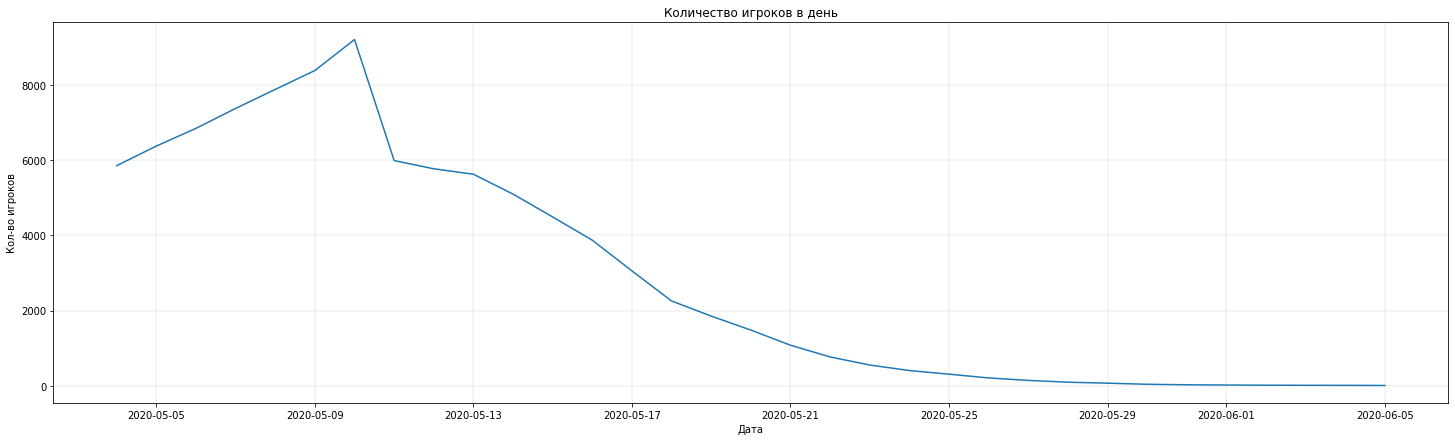

In [15]:
fig, ax = plt.subplots(figsize=(25,7))

ga.groupby('session_date').agg({'user_id': 'nunique'}).plot(ax=ax)
ax.get_legend().remove()
ax.grid(linewidth=0.25)
plt.title('Количество игроков в день')
plt.xlabel('Дата')
plt.ylabel('Кол-во игроков')
plt.show()

Пик игровой активности приходится на 10.05., но т.к. большинство игроков не прошли первый уровень, то этот график отображает, в основном, их поведение. Разделим игроков на группы и посмотрим, как изменится график.

У нас есть три вида игроков:
 - игроки прошедшие первый уровень;
 - любители PVE, прошедшие уровень, выполнив проект;
 - те, кто еще "не определился" (этих товарищей много, предлагаю пока не включать их в график).

In [16]:
ga['event'].unique()

array(['building', 'finished_stage_1', 'project'], dtype=object)

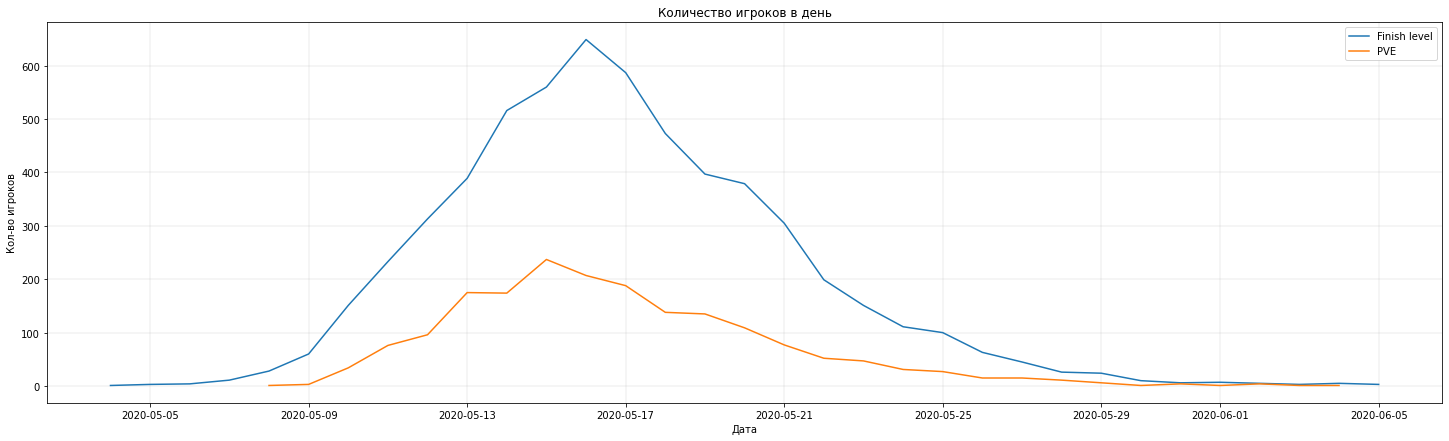

In [18]:
fig, ax = plt.subplots(figsize=(25,7))

ga[ga['event'] != 'building'].groupby(['session_date', 'event']).agg({'user_id': 'nunique'}).unstack().plot(ax=ax)
ax.legend(['Finish level', 'PVE'])
ax.grid(linewidth=0.25)
plt.title('Количество игроков в день')
plt.xlabel('Дата')
plt.ylabel('Кол-во игроков')
plt.show()

А картина интересна. Пик актиности прошедших первый уровень (15.05 - 16.05), приходится на время, когда уже закончились и рекламная акция, и праздники. Похоже, что наши "неопределившиеся" - это любители бесплатных плюшек или просто очень неспешные игроки, которые очень быстро уходят из игры.

**Количество событий в день**

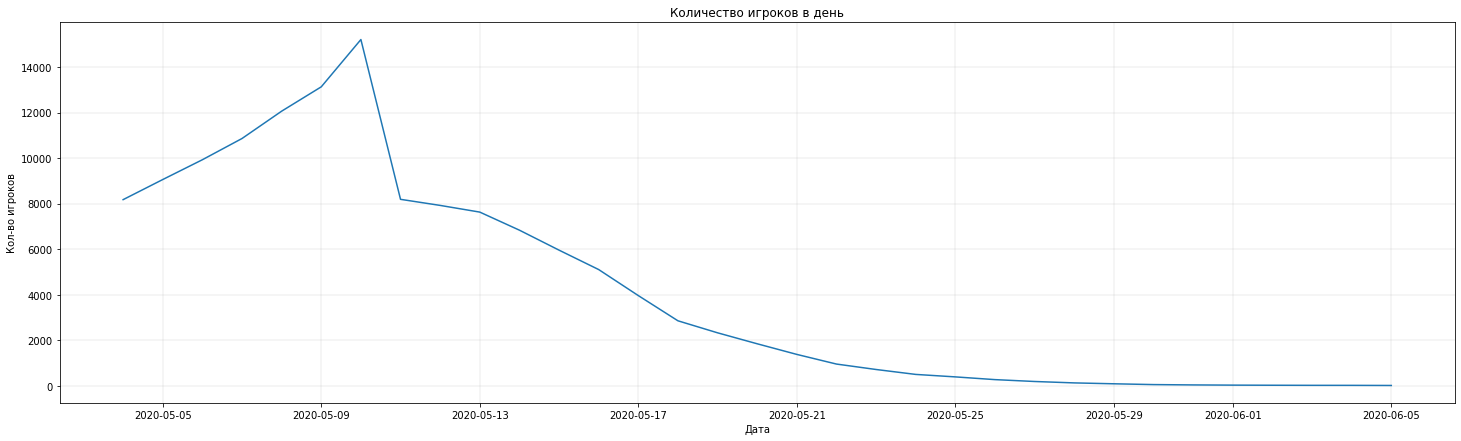

In [19]:
fig, ax = plt.subplots(figsize=(25,7))

ga.groupby('session_date').agg({'event': 'count'}).plot(ax=ax)
ax.get_legend().remove()
ax.grid(linewidth=0.25)
plt.title('Количество игроков в день')
plt.xlabel('Дата')
plt.ylabel('Кол-во игроков')
plt.show()

График событий аналогичен графику активности игров (без разделения по стратегиям).

In [20]:
ga.groupby('user_id').agg({'event': 'count'}).mean()

event   9.99
dtype: float64

На каждого пользователя, в среднем, приходится 9.9 событий.

Теперь посмотрим на отдельные группы игроков.

In [22]:
strategy_pve = ga.query('event=="project"')
users_pve = strategy_pve['user_id'].unique()
ga[ga['user_id'].isin(users_pve)].groupby('user_id').agg({'event': 'count'}).mean()

event   14.65
dtype: float64

In [23]:
finished_level = ga.query('event=="finished_stage_1"')
users_finished = finished_level['user_id'].unique()
ga[ga['user_id'].isin(users_finished)].groupby('user_id').agg({'event': 'count'}).mean()

event   11.77
dtype: float64

In [24]:
in_process = ga.query('event=="building"')
users_process = in_process['user_id'].unique()
ga[ga['user_id'].isin(users_process)].groupby('user_id').agg({'event': 'count'}).mean()

event   9.99
dtype: float64

Полученое ранее число событий показывало колличество событий, которое приходится на человека, не прошедшего первый уровень. Игроки, которые справились с первым заданием, в среднем, выполняли 11.77 <s>действия в случае PVP</s> и 14.65 действия в случае PVE.

### <a id="3.2">Достижение целевого события</a>

Цeлевым событием является прохождение первого уровня.
<br>Для того что бы достичь этой цели, необходимо или выполнить проект, или победить врага, но, в любом случае, для этого необходимо строить здания. На этот параметр и будем опираться.
<br>Раннее мы разделили участников на три типа:
 - pve-игроки - выполнившие проект;
 - игроки прошедшие первый уровень;
 - игроки не прошедшие первый уровень.

Узнаем сколько всего построено зданий и какого типа.

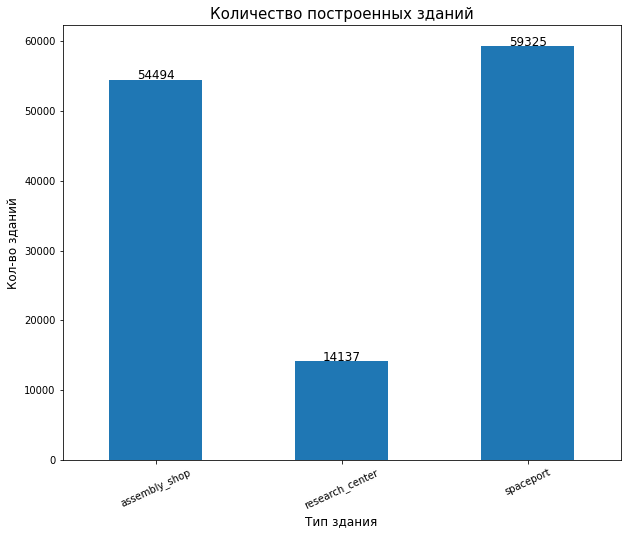

In [25]:
ax = ga.groupby('building_type')['user_id'].count().plot(x='building_type', y='user_id', kind='bar', figsize=(10, 8), rot=25)

for p in ax.patches:
	height = p.get_height()
	ax.text(p.get_x() + p.get_width() / 2,
					height + 50,
					'{:.0f}'.format(height),
					fontsize = 12,
					ha='center')

plt.title('Количество построенных зданий', fontsize=15)
plt.xlabel('Тип здания', fontsize=12)
plt.ylabel('Кол-во зданий', fontsize=12)
plt.show()

Получаем такие итоги:
 - больше всего построено космопортов, это не удивительно, ведь военные юниты нужны всем, как для атаки, так и для обороны;
 - сборочные цехи тоже являются необходимым зданием, ведь нужны рабочие, которые будут добывать ресурсы;
 - исследовательскими центрами большинство игроков пренебрегает, думаю их активно строят те, кто хочет выполнить основной проект.

In [26]:
strategy_pve = ga.query('event=="project"')
users_pve = strategy_pve['user_id'].unique()
ga[ga['user_id'].isin(users_pve)].groupby('user_id').agg({'building_type': 'count'}).mean()

building_type   12.65
dtype: float64

In [27]:
finished_level = ga.query('event=="finished_stage_1"')
users_finished = finished_level['user_id'].unique()
ga[ga['user_id'].isin(users_finished)].groupby('user_id').agg({'building_type': 'count'}).mean()

building_type   10.45
dtype: float64

In [28]:
in_process = ga.query('event=="building"')
users_process = in_process['user_id'].unique()
ga[ga['user_id'].isin(users_process)].groupby('user_id').agg({'building_type': 'count'}).mean()

building_type   9.43
dtype: float64

Из полученной информации можно сделать вывод, что для прохождения первого уровня необходимо в стреднем построить 10.45 зданий <s>при использовании PVP стратегии</s> или 12.65 зданий при использовании в PVE стратегии.

### <a id="3.3">Затраты на привлечение игроков</a>

Теперь перейдем к делу:
 - сначала узнаем сколько пользователей из какого источника пришло;
 - вторым шагом узнаем сколько было потрачено денег на одного пользователя.

In [29]:
# что бы не лазить вверх, откроем таблицы тут
display(ac.head())
display(us.head())

,source,day,cost
0,facebook_ads,2020-05-03,935.88
1,facebook_ads,2020-05-04,548.35
2,facebook_ads,2020-05-05,260.19
3,facebook_ads,2020-05-06,177.98
4,facebook_ads,2020-05-07,111.77


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


**Кол-во привлеченных пользователей**

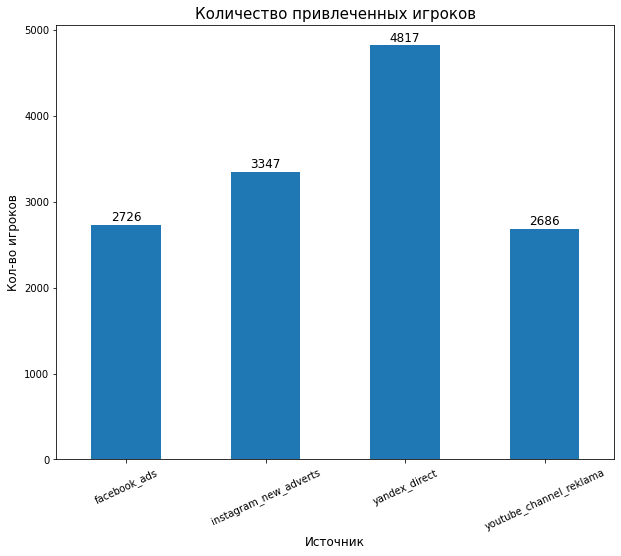

In [30]:
ax = us.groupby('source')['user_id'].count().plot(x='source', y='user_id', kind='bar', figsize=(10, 8), rot=25)

for p in ax.patches:
	height = p.get_height()
	ax.text(p.get_x() + p.get_width() / 2,
					height + 50,
					'{:.0f}'.format(height),
					fontsize = 12,
					ha='center')

plt.title('Количество привлеченных игроков', fontsize=15)
plt.xlabel('Источник', fontsize=12)
plt.ylabel('Кол-во игроков', fontsize=12)
plt.show()

Самым лучшим источником привлечения является "Yandex direct", на втором месте - "Instagram new adverts". С этих источников пришло 4817 и 3347 пользователей соответственно.

**Затраты на привлечение пользователей**

Посчитаем сколько всего мы потратили на рекламу.

In [31]:
print('Всего на привлечение пользователей потрачено', ac['cost'].sum().round(2))

Всего на привлечение пользователей потрачено 7603.58


Чтобы расчитать стоимость привлечения одного пользователя с разных каналов, нам нужно:
 - добавить дату первого входа в таблицу us (user_sourse);
 - объеденить таблицы ac и us;
 - расчитать стоимость привлечения.

In [32]:
first_date = ga.groupby('user_id')['session_date'].min()
first_date.name = 'first_date'
us = us.join(first_date, on='user_id')
display(us.head())
display(us.info())

,user_id,source,first_date
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-06
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,2020-05-06
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,2020-05-05
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-05
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,2020-05-05


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     13576 non-null  object
 1   source      13576 non-null  object
 2   first_date  13576 non-null  object
dtypes: object(3)
memory usage: 318.3+ KB


None

Далее необходимо привести столбец с датами к соответствующему типу данных, посчитать пользователей по датам, и вспомнить, что день оплаты рекламы предшевствует дню первого входа.

In [33]:
us_date = us.groupby(['first_date', 'source']).agg({'user_id': 'nunique'}).reset_index()
us_date.columns=['first_date','source', 'users_count']

us_date['first_date'] = us_date['first_date'].astype('datetime64[s]')
us_date['pay_date'] = us_date['first_date'] - pd.Timedelta(days=1)
us_date.head()

,first_date,source,users_count,pay_date
0,2020-05-04,facebook_ads,1184,2020-05-03
1,2020-05-04,instagram_new_adverts,1452,2020-05-03
2,2020-05-04,yandex_direct,2078,2020-05-03
3,2020-05-04,youtube_channel_reklama,1146,2020-05-03
4,2020-05-05,facebook_ads,694,2020-05-04


Далее необходимо объеденить две таблицы с данными о рекламе.

In [34]:
ad_pay = pd.merge(ac, us_date, how='left', left_on=['day', 'source'], right_on=['pay_date', 'source']).reset_index(drop=True)
ad_pay.head()

,source,day,cost,first_date,users_count,pay_date
0,facebook_ads,2020-05-03,935.88,2020-05-04,1184,2020-05-03
1,facebook_ads,2020-05-04,548.35,2020-05-05,694,2020-05-04
2,facebook_ads,2020-05-05,260.19,2020-05-06,345,2020-05-05
3,facebook_ads,2020-05-06,177.98,2020-05-07,224,2020-05-06
4,facebook_ads,2020-05-07,111.77,2020-05-08,139,2020-05-07


Последний этап:
 - сгруппировать таблицу по источникам;
 - посчитать среднюю стоимость привлечения игрока.

In [35]:
mean_ad_pay = ad_pay.groupby('source').agg({'cost': 'sum', 'users_count': 'sum'}).reset_index()
mean_ad_pay['mean_pay'] = mean_ad_pay['cost'] / mean_ad_pay['users_count']
mean_ad_pay

,source,cost,users_count,mean_pay
0,facebook_ads,2140.90,2726,0.79
1,instagram_new_adverts,2161.44,3347,0.65
2,yandex_direct,2233.11,4817,0.46
3,youtube_channel_reklama,1068.12,2686,0.40


Ценовой диапазон стартует с отметки 0.4 и заканчивается на отметке 0.79 ден.ед.

### <a id="3.4">Активность игроков из разных источников</a>

**Попробуем определить, откуда в игру приходят самые заинтересованные игроки. Будем рассматривать только игроков, завершивших первый уровень.**

In [36]:
ga['event'].unique()

array(['building', 'finished_stage_1', 'project'], dtype=object)

In [37]:
ga_result = ga.drop(ga[ga['event'] == 'building'].index)
ga_result.head()

,event_datetime,event,building_type,user_id,project_type,session_date
6659,2020-05-04 19:47:29,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,NaN,2020-05-04
13134,2020-05-05 13:22:09,finished_stage_1,NaN,7ef7fc89-2779-46ea-b328-9e5035b83af5,NaN,2020-05-05
15274,2020-05-05 18:54:37,finished_stage_1,NaN,70db22b3-c2f4-43bc-94ea-51c8d2904a29,NaN,2020-05-05
16284,2020-05-05 21:27:29,finished_stage_1,NaN,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,NaN,2020-05-05
19650,2020-05-06 06:02:22,finished_stage_1,NaN,58e077ba-feb1-4556-a5a0-d96bd04efa39,NaN,2020-05-06


In [38]:
ga_source = ga_result.merge(us, how='left', left_on='user_id', right_on='user_id')
ga_source.head()

,event_datetime,event,building_type,user_id,project_type,session_date,source,first_date
0,2020-05-04 19:47:29,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,NaN,2020-05-04,instagram_new_adverts,2020-05-04
1,2020-05-05 13:22:09,finished_stage_1,NaN,7ef7fc89-2779-46ea-b328-9e5035b83af5,NaN,2020-05-05,facebook_ads,2020-05-04
2,2020-05-05 18:54:37,finished_stage_1,NaN,70db22b3-c2f4-43bc-94ea-51c8d2904a29,NaN,2020-05-05,youtube_channel_reklama,2020-05-04
3,2020-05-05 21:27:29,finished_stage_1,NaN,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,NaN,2020-05-05,youtube_channel_reklama,2020-05-04
4,2020-05-06 06:02:22,finished_stage_1,NaN,58e077ba-feb1-4556-a5a0-d96bd04efa39,NaN,2020-05-06,facebook_ads,2020-05-04


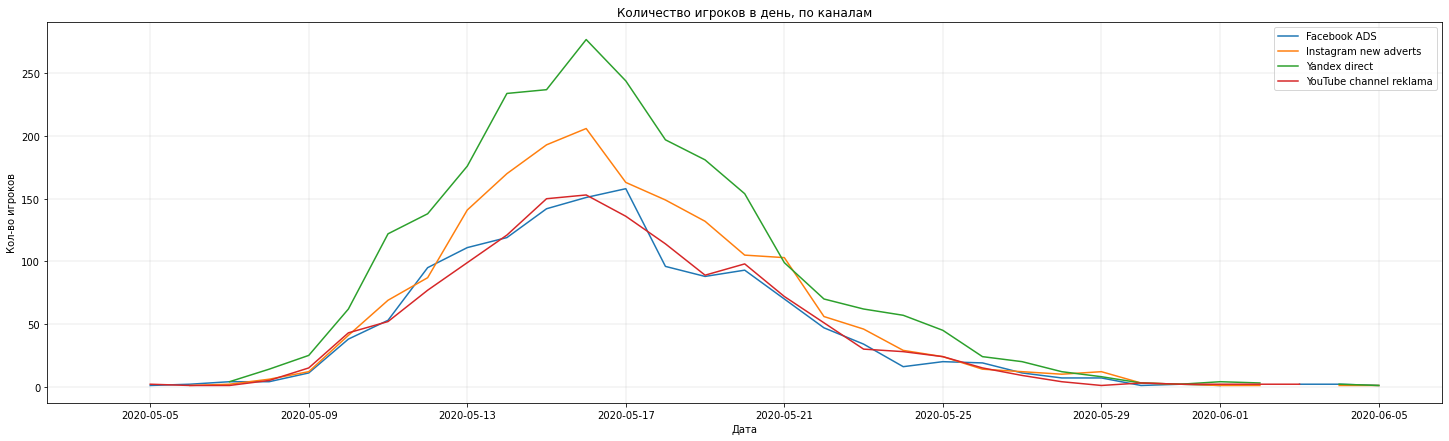

In [39]:
fig, ax = plt.subplots(figsize=(25,7))

ga_source.groupby(['session_date', 'source']).agg({'user_id': 'nunique'}).unstack().plot(ax=ax)
ax.legend(['Facebook ADS', 'Instagram new adverts', 'Yandex direct', 'YouTube channel reklama'])
ax.grid(linewidth=0.25)
plt.title('Количество игроков в день, по каналам')
plt.xlabel('Дата')
plt.ylabel('Кол-во игроков')
plt.show()

Итак, мы получили следующий результат:
 - самые заинтересованные игроки приходят из Yandex direct;
 - на втором месте находится Instagram new adverts;
 - YouTube и Facebook приносят примерно одинаковое кол-во игроков, но меньше, чем предыдущие каналы.

Если принять по внимание стоимость привлечения одного игрока, то самыми выгодными каналами, на данный момен, являются Яндекс и Инстаграм.

## <a id="verification">Проверка гипотез</a>

### <a id="4.1">Различается ли среднее время прохождения первого уровня игроками победившими врага и выполневшими проект</a>

Н0: Среднее время прохождения уровня игроком, победившим врага, меньше, чем время игрока, реализовавшего проект
<br>Н1: Среднее время прохождения уровня игроком, победившим врага, больше, чем время игрока, реализовавшего проект

Данную гипотезу будем проверять с помощью t-теста.

<br>Для проверки этой гипотезы нам необходимо узнать время, за которое игроки проходят первый уровень. Для удобства переведем это время в секунды.

In [41]:
# список пользователей закончивших уровень
ga_fin = ga[ga['event'] != 'building'][['user_id', 'event']]
ga_fin

,user_id,event
6659,ced7b368-818f-48f6-9461-2346de0892c5,finished_stage_1
13134,7ef7fc89-2779-46ea-b328-9e5035b83af5,finished_stage_1
15274,70db22b3-c2f4-43bc-94ea-51c8d2904a29,finished_stage_1
16284,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,finished_stage_1
19650,58e077ba-feb1-4556-a5a0-d96bd04efa39,finished_stage_1
...,...,...
135632,22cce310-fe10-41a2-941b-9c3d63327fea,finished_stage_1
135633,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,finished_stage_1
135636,515c1952-99aa-4bca-a7ea-d0449eb5385a,finished_stage_1
135638,32572adb-900f-4b5d-a453-1eb1e6d88d8b,finished_stage_1


In [42]:
# список пользователей завершивших проект
ga_pve = ga_fin[ga_fin['event'] == 'project'][['user_id', 'event']]
ga_pve

,user_id,event
47121,e3c66498-9d45-4000-9392-f81e6796e7da,project
57398,936e7af6-8338-4703-a1df-fc6c3f5b8e34,project
58797,a4491c86-c498-4f74-a56e-65c136d0e9a1,project
61174,85d9e675-562b-4329-8bbd-14d3b39096be,project
63770,1889ca71-3c57-4e61-9ea6-a711971bbf0a,project
...,...,...
135602,9d98001c-7e14-40d7-896e-46b3047365fd,project
135603,df4a1e13-eba9-4928-a7cf-ee303d6f80f9,project
135609,82e46f34-e243-4728-8e20-2e171fc33ea4,project
135617,fe032991-71e0-48c5-889f-4c3805ba4c9b,project


In [43]:
# список пользователей победивших противника
ga_pvp = ga_fin[~ga_fin.isin(ga_pve['user_id'].unique())].dropna()
ga_pvp

,user_id,event
6659,ced7b368-818f-48f6-9461-2346de0892c5,finished_stage_1
13134,7ef7fc89-2779-46ea-b328-9e5035b83af5,finished_stage_1
15274,70db22b3-c2f4-43bc-94ea-51c8d2904a29,finished_stage_1
16284,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,finished_stage_1
19650,58e077ba-feb1-4556-a5a0-d96bd04efa39,finished_stage_1
...,...,...
135628,18fc6a86-00e7-4f3e-96da-bdb6d550415c,finished_stage_1
135632,22cce310-fe10-41a2-941b-9c3d63327fea,finished_stage_1
135636,515c1952-99aa-4bca-a7ea-d0449eb5385a,finished_stage_1
135638,32572adb-900f-4b5d-a453-1eb1e6d88d8b,finished_stage_1


In [44]:
# сформируем таблицу с временем прохождения первого уровня для PVE
pve_time = pd.merge(ga_pve, ga, how='left', on=['user_id', 'event'])
pve_time['session_date'] = pve_time['session_date'].astype('datetime64[s]')
pve_time['win_time'] = pve_time['event_datetime'] - pve_time['session_date']
pve_time['win_time'] = pve_time['win_time'].dt.total_seconds()
pve_time

,user_id,event,event_datetime,building_type,project_type,session_date,win_time
0,e3c66498-9d45-4000-9392-f81e6796e7da,project,2020-05-08 18:10:25,NaN,satellite_orbital_assembly,2020-05-08,65425.00
1,936e7af6-8338-4703-a1df-fc6c3f5b8e34,project,2020-05-09 13:49:11,NaN,satellite_orbital_assembly,2020-05-09,49751.00
2,a4491c86-c498-4f74-a56e-65c136d0e9a1,project,2020-05-09 16:19:33,NaN,satellite_orbital_assembly,2020-05-09,58773.00
3,85d9e675-562b-4329-8bbd-14d3b39096be,project,2020-05-09 20:29:01,NaN,satellite_orbital_assembly,2020-05-09,73741.00
4,1889ca71-3c57-4e61-9ea6-a711971bbf0a,project,2020-05-10 00:57:47,NaN,satellite_orbital_assembly,2020-05-10,3467.00
...,...,...,...,...,...,...,...
1861,9d98001c-7e14-40d7-896e-46b3047365fd,project,2020-06-02 03:04:42,NaN,satellite_orbital_assembly,2020-06-02,11082.00
1862,df4a1e13-eba9-4928-a7cf-ee303d6f80f9,project,2020-06-02 06:21:03,NaN,satellite_orbital_assembly,2020-06-02,22863.00
1863,82e46f34-e243-4728-8e20-2e171fc33ea4,project,2020-06-02 17:17:28,NaN,satellite_orbital_assembly,2020-06-02,62248.00
1864,fe032991-71e0-48c5-889f-4c3805ba4c9b,project,2020-06-03 09:46:04,NaN,satellite_orbital_assembly,2020-06-03,35164.00


In [45]:
# сформируем таблицу с временем прохождения первого уровня для PVP
pvp_time = pd.merge(ga_pvp, ga, how='left', on=['user_id', 'event'])
pvp_time['session_date'] = pvp_time['session_date'].astype('datetime64[s]')
pvp_time['win_time'] = pvp_time['event_datetime'] - pvp_time['session_date']
pvp_time['win_time'] = pvp_time['win_time'].dt.total_seconds()
pvp_time

,user_id,event,event_datetime,building_type,project_type,session_date,win_time
0,ced7b368-818f-48f6-9461-2346de0892c5,finished_stage_1,2020-05-04 19:47:29,NaN,NaN,2020-05-04,71249.00
1,7ef7fc89-2779-46ea-b328-9e5035b83af5,finished_stage_1,2020-05-05 13:22:09,NaN,NaN,2020-05-05,48129.00
2,70db22b3-c2f4-43bc-94ea-51c8d2904a29,finished_stage_1,2020-05-05 18:54:37,NaN,NaN,2020-05-05,68077.00
3,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,finished_stage_1,2020-05-05 21:27:29,NaN,NaN,2020-05-05,77249.00
4,58e077ba-feb1-4556-a5a0-d96bd04efa39,finished_stage_1,2020-05-06 06:02:22,NaN,NaN,2020-05-06,21742.00
...,...,...,...,...,...,...,...
3946,18fc6a86-00e7-4f3e-96da-bdb6d550415c,finished_stage_1,2020-06-04 06:44:02,NaN,NaN,2020-06-04,24242.00
3947,22cce310-fe10-41a2-941b-9c3d63327fea,finished_stage_1,2020-06-04 15:50:38,NaN,NaN,2020-06-04,57038.00
3948,515c1952-99aa-4bca-a7ea-d0449eb5385a,finished_stage_1,2020-06-05 02:25:12,NaN,NaN,2020-06-05,8712.00
3949,32572adb-900f-4b5d-a453-1eb1e6d88d8b,finished_stage_1,2020-06-05 12:12:27,NaN,NaN,2020-06-05,43947.00


In [46]:
pvp_winner = pvp_time['win_time']
pve_winner = pve_time['win_time']

In [47]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    pvp_winner,
    pve_winner)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.7771998540147199
Не получилось отвергнуть нулевую гипотезу


Есть статистически значимые различия между временем прохождения первого уровня игроками, которые победили врага и игроками, которые выполнили проект.
<br>Состоятельно утверждение о том, что игроки побеждающие врагов проходят уровень быстрее.

### <a id="4.2">Можно ли сказать, что с определенного источника приходят любители определенной стратегии</a>

Н0: Нет связи между рекламным источником и стратегией игрока
<br>Н1: Есть связь между рекламным источником и стратегией игрока

Т.к. в данной гипотезе мы будем проверять не связанные друг с другом выборки, то применим метод Манна-Уитни. Так же из-за того что проверка будет множественной применним поправку Бонферрони.

In [50]:
users_finished = ga_source[(ga_source['event'] != 'building')][['user_id', 'event', 'source']]
users_finished

,user_id,event,source
0,ced7b368-818f-48f6-9461-2346de0892c5,finished_stage_1,instagram_new_adverts
1,7ef7fc89-2779-46ea-b328-9e5035b83af5,finished_stage_1,facebook_ads
2,70db22b3-c2f4-43bc-94ea-51c8d2904a29,finished_stage_1,youtube_channel_reklama
3,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,finished_stage_1,youtube_channel_reklama
4,58e077ba-feb1-4556-a5a0-d96bd04efa39,finished_stage_1,facebook_ads
...,...,...,...
7678,22cce310-fe10-41a2-941b-9c3d63327fea,finished_stage_1,yandex_direct
7679,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,finished_stage_1,facebook_ads
7680,515c1952-99aa-4bca-a7ea-d0449eb5385a,finished_stage_1,yandex_direct
7681,32572adb-900f-4b5d-a453-1eb1e6d88d8b,finished_stage_1,facebook_ads


In [51]:
users_pve = ga_source[ga_source['event'] == 'project'][['user_id', 'event', 'source']]
users_pve

,user_id,event,source
41,e3c66498-9d45-4000-9392-f81e6796e7da,project,youtube_channel_reklama
83,936e7af6-8338-4703-a1df-fc6c3f5b8e34,project,facebook_ads
87,a4491c86-c498-4f74-a56e-65c136d0e9a1,project,yandex_direct
99,85d9e675-562b-4329-8bbd-14d3b39096be,project,youtube_channel_reklama
118,1889ca71-3c57-4e61-9ea6-a711971bbf0a,project,instagram_new_adverts
...,...,...,...
7663,9d98001c-7e14-40d7-896e-46b3047365fd,project,yandex_direct
7664,df4a1e13-eba9-4928-a7cf-ee303d6f80f9,project,youtube_channel_reklama
7667,82e46f34-e243-4728-8e20-2e171fc33ea4,project,youtube_channel_reklama
7670,fe032991-71e0-48c5-889f-4c3805ba4c9b,project,facebook_ads


In [52]:
users_pvp = users_finished[~users_finished.isin(users_pve['user_id'].unique())].dropna()
users_pvp

,user_id,event,source
0,ced7b368-818f-48f6-9461-2346de0892c5,finished_stage_1,instagram_new_adverts
1,7ef7fc89-2779-46ea-b328-9e5035b83af5,finished_stage_1,facebook_ads
2,70db22b3-c2f4-43bc-94ea-51c8d2904a29,finished_stage_1,youtube_channel_reklama
3,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,finished_stage_1,youtube_channel_reklama
4,58e077ba-feb1-4556-a5a0-d96bd04efa39,finished_stage_1,facebook_ads
...,...,...,...
7675,18fc6a86-00e7-4f3e-96da-bdb6d550415c,finished_stage_1,yandex_direct
7678,22cce310-fe10-41a2-941b-9c3d63327fea,finished_stage_1,yandex_direct
7680,515c1952-99aa-4bca-a7ea-d0449eb5385a,finished_stage_1,yandex_direct
7681,32572adb-900f-4b5d-a453-1eb1e6d88d8b,finished_stage_1,facebook_ads


In [53]:
users_pve['user_strategy'] = 0
users_pvp['user_strategy'] = 1

In [54]:
hypothes = pd.concat([users_pve, users_pvp])
hypothes

,user_id,event,source,user_strategy
41,e3c66498-9d45-4000-9392-f81e6796e7da,project,youtube_channel_reklama,0
83,936e7af6-8338-4703-a1df-fc6c3f5b8e34,project,facebook_ads,0
87,a4491c86-c498-4f74-a56e-65c136d0e9a1,project,yandex_direct,0
99,85d9e675-562b-4329-8bbd-14d3b39096be,project,youtube_channel_reklama,0
118,1889ca71-3c57-4e61-9ea6-a711971bbf0a,project,instagram_new_adverts,0
...,...,...,...,...
7675,18fc6a86-00e7-4f3e-96da-bdb6d550415c,finished_stage_1,yandex_direct,1
7678,22cce310-fe10-41a2-941b-9c3d63327fea,finished_stage_1,yandex_direct,1
7680,515c1952-99aa-4bca-a7ea-d0449eb5385a,finished_stage_1,yandex_direct,1
7681,32572adb-900f-4b5d-a453-1eb1e6d88d8b,finished_stage_1,facebook_ads,1


In [55]:
# сделаем выборки для каналов
instagram_new_adverts = hypothes[hypothes['source'] == 'instagram_new_adverts']['user_strategy']
facebook_ads = hypothes[hypothes['source'] == 'facebook_ads']['user_strategy']
youtube_channel_reklama = hypothes[hypothes['source'] == 'youtube_channel_reklama']['user_strategy']
yandex_direct = hypothes[hypothes['source'] == 'yandex_direct']['user_strategy']

In [56]:
def check_hypothes(H0, H1, name):
    print(name)

    alpha = .05 / 12

    results = st.mannwhitneyu(H0, H1)

    print('p-значение:', results.pvalue)

    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
        
    print('-' * 50)

In [57]:
check_hypothes(instagram_new_adverts, facebook_ads, 'Instagram & Facebook')
check_hypothes(instagram_new_adverts, youtube_channel_reklama, 'Instagram & YouTube')
check_hypothes(instagram_new_adverts, yandex_direct, 'Instagram & Yandex')
check_hypothes(facebook_ads, instagram_new_adverts, 'Facebook & Instagram')
check_hypothes(facebook_ads, youtube_channel_reklama, 'Facebook & Youtube')
check_hypothes(facebook_ads, yandex_direct, 'Facebook & Yandex')
check_hypothes(youtube_channel_reklama, instagram_new_adverts, 'YouTube & Instagram')
check_hypothes(youtube_channel_reklama, facebook_ads, 'YouTube & Facebook')
check_hypothes(youtube_channel_reklama, yandex_direct, 'YouTube & Yandex')
check_hypothes(yandex_direct, instagram_new_adverts, 'Yandex & Instagram')
check_hypothes(yandex_direct, facebook_ads, 'Yandex & Facebook')
check_hypothes(yandex_direct, youtube_channel_reklama, 'Yandex & YouTube')

Instagram & Facebook
p-значение: 0.40919319567631285
Не получилось отвергнуть нулевую гипотезу
--------------------------------------------------
Instagram & YouTube
p-значение: 0.9001181567908461
Не получилось отвергнуть нулевую гипотезу
--------------------------------------------------
Instagram & Yandex
p-значение: 0.18426828022587327
Не получилось отвергнуть нулевую гипотезу
--------------------------------------------------
Facebook & Instagram
p-значение: 0.40919319567631285
Не получилось отвергнуть нулевую гипотезу
--------------------------------------------------
Facebook & Youtube
p-значение: 0.5079689382321106
Не получилось отвергнуть нулевую гипотезу
--------------------------------------------------
Facebook & Yandex
p-значение: 0.033959962425478496
Не получилось отвергнуть нулевую гипотезу
--------------------------------------------------
YouTube & Instagram
p-значение: 0.9001181567908461
Не получилось отвергнуть нулевую гипотезу
----------------------------------------

Связи между рекламными каналами, с которых приходят игроки, и их предпочтениями в стратегии игры нет.

## <a id="monetization_model">Модель монетизации</a>

**На этом этапе опишем предложенную модель монетизации.**

Рассмотрим модель монетизации с показом рекламы при выборе объектов строительства.

Исходя из раннее проведенного исследования мы знаем:
 - затраты на привлечение игроков 7603.57 ден.ед.;
 - кол-во привлеченных игроков 13576 человек;
 - стоимости показа одного рекламного баннера 0,07 ден.ед.;
 - в среднем, игрок строит от 9 зданий.

Расчетная нулевая отметка окупаемости проекта находится на значении (7603,57 / 13576 / 0,07) = 8 показов на человека.

Поэтому, можно предположить, что стратегия пропуска показа рекламы при первом строительстве будет выводить проект на окупаемость. При двух и более - будет убыточной.

Проверим расчеты на текущих данных:

In [58]:
df = ga[ga['event'] == 'building'].groupby(
    'user_id').agg({'building_type': 'count'}).reset_index().sort_values('building_type', ascending=False)
df.columns=['user_id', 'showing_count']
df

,user_id,showing_count
8799,a5add3ce-1ac4-4b97-aba0-f040efc4c1b0,20
8644,a2f85d5e-5a53-43ee-9d41-9e1def085562,20
10120,bf542075-e3a2-4e79-82d8-3838e86d2a25,20
1592,1cb5b622-be18-488e-b699-6136a57eb470,20
11329,d6aca06a-cd75-4cd8-b8cd-240a3c163884,20
...,...,...
6601,7ac32352-627b-421c-9319-b77a37947625,1
4494,531a93d9-f57d-4b60-8eec-ee709ff7c67c,1
11954,e17fd642-a43d-41d4-86a8-c81c6107f9cc,1
7406,8a6262b0-0521-4691-bfd2-8d74cf7a5e93,1


Удалим пользователей с одним показом рекламы

In [59]:
df = df.drop(df[df['showing_count'] == 1].index)

In [60]:
df['showing'] = df['showing_count'] - 1
df['showing'].sum() * 0.07

8006.6

Сумма полученая с учетом одного пропуска рекламы покрывает расходы на привлечение игроков, и выводит нас на окупаемость при текущих данных.

In [61]:
df['showing'] = df['showing_count'] - 2
df['showing'].sum() * 0.07

7060.27

При пропуске 2 показов рекламы в меню строительства общая выручка не покрывает затраты на рекламу, следовательно, мы можем пропустить только один показ рекламы при первом строительстве.

Увеличение пропусков показа рекламы в меню строительства потребуют увеличения стоимости показа рекламы:
- для пропуска первых 2х зданий - до 0.08 ден.ед.;
- для пропуска первых 3х зданий - до 0.09 ден.ед.

Так же, для повышения доходности, можно добавить просмотр рекламы при переходе на следующий уровень.

In [62]:
df.sort_values('showing_count', ascending=False)

,user_id,showing_count,showing
8799,a5add3ce-1ac4-4b97-aba0-f040efc4c1b0,20,18
13550,ff841992-d93b-462e-bc6e-18c24a514f36,20,18
9780,b8a01939-eb2d-4021-a1fb-c3f2a52fa176,20,18
10937,cefc5aac-4011-4e00-becc-2634c4527713,20,18
8814,a5f59d60-98b8-4455-ae5b-308f44715557,20,18
...,...,...,...
7388,8a1cbd21-b898-4aee-be95-c38f7a5a28fd,2,0
7411,8a782485-46be-432d-8413-9777a586df52,2,0
2521,2dbf40b8-23ed-4de2-b3eb-4efd5d150faa,2,0
10100,beee971c-4553-4e79-abd7-1f4fc852b60b,2,0


## <a id="marketing">Маркетинг</a>

Анализ проведем с помощью метрик LTV.

### <a id="5.1">Расчет LTV</a>

In [63]:
ga_for_cohort = ga.merge(us, how='left', left_on='user_id', right_on='user_id')
ga_for_cohort.head()

,event_datetime,event,building_type,user_id,project_type,session_date,source,first_date
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,youtube_channel_reklama,2020-05-04
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04,facebook_ads,2020-05-04
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04,instagram_new_adverts,2020-05-04
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04,facebook_ads,2020-05-04
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04,yandex_direct,2020-05-04


In [64]:
ga_for_cohort.drop(columns=['session_date', 'first_date'], axis=1, inplace=True)
ga_for_cohort.head()

,event_datetime,event,building_type,user_id,project_type,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,facebook_ads
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,yandex_direct


In [65]:
ga_for_cohort['event_day'] = ga_for_cohort['event_datetime'].astype('datetime64[D]')
ga_for_cohort.head()

,event_datetime,event,building_type,user_id,project_type,source,event_day
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama,2020-05-04
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads,2020-05-04
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts,2020-05-04
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,facebook_ads,2020-05-04
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,yandex_direct,2020-05-04


In [66]:
first_day = ga_for_cohort.groupby(['source', 'user_id']).agg({'event_day': 'min'}).reset_index()
first_day.columns = ['source', 'user_id', 'first_event_day']
first_day.head()

,source,user_id,first_event_day
0,facebook_ads,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06
1,facebook_ads,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05
2,facebook_ads,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04
3,facebook_ads,00440efd-aa50-4b4b-aae8-ffcd1782729d,2020-05-04
4,facebook_ads,00965328-5e54-453f-b11b-52f8ae9ae80b,2020-05-07


In [67]:
cohort_size = first_day.groupby(['source', 'first_event_day']).agg({'user_id':'nunique'}).reset_index()
cohort_size.columns = ['source', 'first_event_day', 'users_count']
cohort_size.head()

,source,first_event_day,users_count
0,facebook_ads,2020-05-04,1184
1,facebook_ads,2020-05-05,694
2,facebook_ads,2020-05-06,345
3,facebook_ads,2020-05-07,224
4,facebook_ads,2020-05-08,139


In [68]:
cohort_buildings = pd.merge(ga_for_cohort, first_day, on=['user_id', 'source'])
cohort_buildings['revenue'] = 0.07
cohort_buildings.head()

,event_datetime,event,building_type,user_id,project_type,source,event_day,first_event_day,revenue
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama,2020-05-04,2020-05-04,0.07
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama,2020-05-05,2020-05-04,0.07
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama,2020-05-05,2020-05-04,0.07
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama,2020-05-05,2020-05-04,0.07
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama,2020-05-06,2020-05-04,0.07


In [69]:
cohorts = (
    cohort_buildings.groupby(['source', 'first_event_day', 'event_day'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
cohorts.head()

,source,first_event_day,event_day,revenue
0,facebook_ads,2020-05-04,2020-05-04,115.99
1,facebook_ads,2020-05-04,2020-05-05,61.18
2,facebook_ads,2020-05-04,2020-05-06,69.51
3,facebook_ads,2020-05-04,2020-05-07,72.45
4,facebook_ads,2020-05-04,2020-05-08,83.37


In [70]:
cohort_ltv = pd.merge(cohort_size, cohorts, on=['source', 'first_event_day'])
cohort_ltv.head()

,source,first_event_day,users_count,event_day,revenue
0,facebook_ads,2020-05-04,1184,2020-05-04,115.99
1,facebook_ads,2020-05-04,1184,2020-05-05,61.18
2,facebook_ads,2020-05-04,1184,2020-05-06,69.51
3,facebook_ads,2020-05-04,1184,2020-05-07,72.45
4,facebook_ads,2020-05-04,1184,2020-05-08,83.37


In [71]:
cohort_ltv['age'] = (cohort_ltv['event_day'] - cohort_ltv['first_event_day']) / np.timedelta64(1, 'D')
cohort_ltv['age'] = cohort_ltv['age'].round().astype('int')
cohort_ltv['ltv'] = cohort_ltv['revenue'] / cohort_ltv['users_count']
cohort_ltv['first_event_day'] = cohort_ltv['first_event_day'].dt.strftime('%Y-%m-%d')
cohort_ltv.head()

,source,first_event_day,users_count,event_day,revenue,age,ltv
0,facebook_ads,2020-05-04,1184,2020-05-04,115.99,0,0.10
1,facebook_ads,2020-05-04,1184,2020-05-05,61.18,1,0.05
2,facebook_ads,2020-05-04,1184,2020-05-06,69.51,2,0.06
3,facebook_ads,2020-05-04,1184,2020-05-07,72.45,3,0.06
4,facebook_ads,2020-05-04,1184,2020-05-08,83.37,4,0.07


In [72]:
fin_table = cohort_ltv.pivot_table(
            index='first_event_day', 
            columns='age', 
            values='ltv', 
            aggfunc='mean').round(2)

fin_table = fin_table.cumsum(axis=1).round(2)

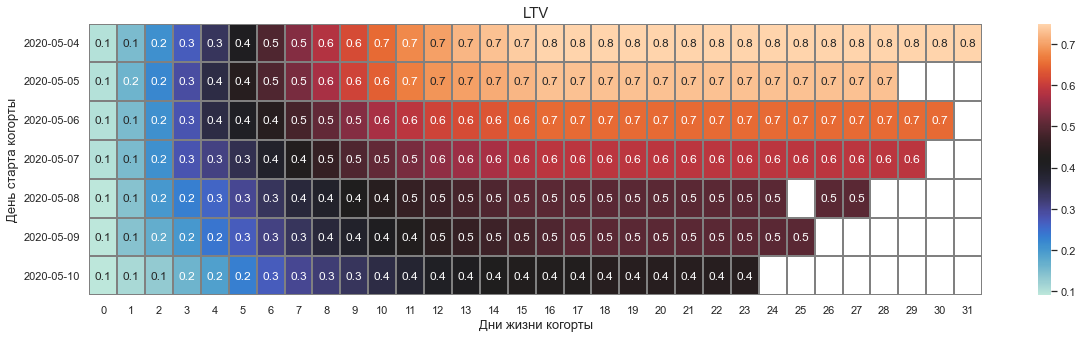

In [73]:
sns.set(style='white')
plt.figure(figsize=(20, 5))
plt.title('LTV', fontsize=15)
ax=sns.heatmap(fin_table, annot=True, fmt='.1f', linewidths=.01, linecolor='gray', cmap="icefire")
ax.set_ylabel('День старта когорты', fontsize=13)
ax.set_xlabel('Дни жизни когорты', fontsize=13)
plt.show()

Показатели LTV стабильны, и увеличиваются на протяжении жизни каждой когорты.

## <a id="conclusion">Общий вывод</a>

**В ходе работы мы:**
 - провели предобработку данных;
 - провели исследовательский анализ;
 - проверили гипотезу о разнице во времени прохождения первого уровня между PVP и PVE игроками;
 - проверили окупаемость вложений в рекламные кампании.

**В процессе исследовательского анализа данных данных мы установили:**

 - пик активности всех игроков приходится на 10.05, к 11.05 происходит резкое снижение активности, далее активность плавно снижается;
 - при делении игроков закончивших уровень, и реализовавших проект:
        <br>- пик активности приходится на 15.05 и 16.05;
		<br>- кол-во игроков избравших своей стратегией уничтожение противников преобладает над игроками выбравшими путь ученых.
		
 - среднее кол-во событий в день:
		<br>- среди игроков реализовавших проект - 14.65;
		<br>- среди игроков завершивших уровень - 11.77;
		<br>- среди игроков не прошедших первый уровень - 9.99.

 - для достижения целевого события (прохождения первого уровня) в день игроками было построено:
		<br>- в среднем игроками реализовавшими проект - 12.65;
		<br>- в среднем игроками завершившими уровень - 10.45;
		<br>- в среднем игроками не прошедшими первый уровень - 9.43;
		<br>- всего построено - 127 956 зданий, из них:
						<br>a. assembly_shop - 54 494;
						<br>b. spaceport - 59 325;
						<br>c. research_center - 14 137.

 - Было привлечено:
		<br>- из facebook_ads - 2726 чел.: 
						<br>a. общая стоимость 2140.90 ден.ед.; 
						<br>b. средняя стоимость привлечения 1 чел = 0.79 ден.ед.
		<br>- из instagram_new_adverts - 3347 чел.: 
						<br>a. общая стоимость 2161.44 ден.ед.; 
						<br>b. средняя стоимость привлечения 1 чел = 0.65 ден.ед.
		<br>- из yandex_direct - 4817 чел.: 
						<br>a. общая стоимость 2233.11 ден.ед.; 
						<br>b. средняя стоимость привлечения 1 чел = 0.46 ден.ед.
		<br>- из youtube_channel_reklama - 2686 чел.: 
						<br>a. общая стоимость 1068.12 ден.ед.; 
						<br>b. средняя стоимость привлечения 1 чел = 0.40 ден.ед.
		<br>- всего было привлечено - 13576 чел. за 7603.58 ден.ед.

 - Были проверены гипотезы:
		<br>1. Различается ли среднее время прохождения первого уровня игроками победившими врага и выполневшими проект
		<br>Было установлено, что есть статистически значимые различия между временем прохождения первого уровня PVP и PVE игроками. Можно сказать, что утверждение о том что PVP-игроки проходят первый уровень быстрее - состоятельно.
        <br>2. Можно ли сказать, что с определенного источника приходят любители определенной стратегии
        <br>Было установлено, что источник, с которого приходит игрок, не связан с его пристрастием к PVP или PVE стратегии

## <a id="recommendations">Рекомендации</a>

 1. Для более лучшего вовлечения игроков возможно сдвинуть первый показ рекламы на 1 строительство, для большего кол-ва пропусков рекламы необходимо повышать стоимость показа рекламы;
 2. Для удержания игроков предлагаю организовывать внутриигровые эвенты, как PVP так и PVE направленности;
 3. Думаю, что есть смысл провести отдельный анализ для PVE направления, на данный момент оно слабо развито по сравнению с PVP;
 4. Стратегию показа рекламного баннера в меню выбора построек считаю состоятельной.